# Задание к занятию «Борьба с переобучением: ансамблирование»

## Подготовка данных

Категориальные и числовые данные будем готовить по разному.
Категориальные сразу и сейчас.
Числовые (Imputer, Scaler) позднее в рамках pipeline для каждой модели. Например, при заполнение NaN  в рамках конвейра, среднее значение мы всегда будем вычислять только данных тренировочного набора, чтобы не допустить утечку данных из тестового набора. Ну как-то так.

In [29]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

In [30]:
X_full = pd.read_csv('train.csv.gz', compression='gzip', index_col='Id')
X_val = pd.read_csv('test.csv.gz', compression='gzip', index_col='Id')

In [31]:
X_full.shape, X_val.shape

((1460, 80), (1459, 79))

In [32]:
X_full.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Признак MSSubClass является категориальным, но ожидаемо распарсился, как число. Переопределяем, как строку

In [33]:
X_full.MSSubClass = X_full.MSSubClass.astype('str')
X_val.MSSubClass = X_val.MSSubClass.astype('str')
X_full.SalePrice = X_full.SalePrice.astype('float64')
y_full = X_full.SalePrice
X_full.drop('SalePrice', axis=1, inplace=True)

In [34]:
#X_full.info()

In [35]:
#data.isnull().sum()
#newdf = data.select_dtypes(include=[np.number]).columns
cat_feat = X_full.dtypes[X_full.dtypes == "object"].index.tolist()
num_feat = X_full.dtypes[X_full.dtypes != "object"].index.tolist()
set(X_full.columns) == set(cat_feat + num_feat)

True

In [36]:
#X_full[cat_feat].nunique().sort_values(ascending=False)
#X_full.Neighborhood.value_counts()

In [37]:
X_full[cat_feat] = X_full[cat_feat].fillna('nan')
X_val[cat_feat] = X_val[cat_feat].fillna('nan')

In [38]:
X_full[cat_feat].shape

(1460, 44)

In [39]:
#pd.get_dummies(X_full).columns.tolist()

После dummy кодирования оставляем только те категориальные  dummy признаки, которые есть как в тренировочном, так и проверочном набрах.

In [40]:
dummy_full = pd.get_dummies(X_full[cat_feat], columns=cat_feat)
dummy_val = pd.get_dummies(X_val[cat_feat], columns=cat_feat)

cat_feat = list(set(dummy_full) & set(dummy_val))

dummy_full = dummy_full[cat_feat]
dummy_val = dummy_val[cat_feat]
X_full = pd.concat([X_full[num_feat], dummy_full], axis=1)
X_val = pd.concat([X_val[num_feat], dummy_val], axis=1)


In [41]:
X_full.shape, X_val.shape

((1460, 299), (1459, 299))

In [42]:
X_full.isnull().sum().sort_values(ascending=False).head()

LotFrontage           259
GarageYrBlt            81
MasVnrArea              8
GarageType_CarPort      0
Street_Grvl             0
dtype: int64

## Базовые модели

В качестве базовых моделей будем рассматривать KNeighborsRegressor, линейные модели с разной регуляризацией (Ridge, Lasso, ElasticNet), обычное дерево (DecisionTreeRegressor) и SVR я ядром RBF.
Подбор гиперпараметров будем проиводить с помощью GridSearchCV

In [43]:
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline#, FeatureUnion
#from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor

#DataFrameSelector будет использоваться в конвейере для разделения числовых и категориальных признаков
#class DataFrameSelector(BaseEstimator):
#    """
#    Create a class to select numerical or categorical columns 
#    """
#    def __init__(self, column_names):
#        self.column_names = column_names
#    def fit(self, X, y=None):
#        return self
#    def transform(self, X):
#        return X[self.column_names].values

### Подготовка конвейера

Создаем два отдельных конвейра
- для моделей, которым требуестя стандартизация числовых признаков prep_imputed_scaled
- для моделей, которым стандартизация не требуется prep_imputed (для деревянных моделей)

DataFrameSelector используестя для разделения признаков
FeatureUnion используется для объединения категориальных и числовх признаков после их параллельной обработки


In [44]:
#num_imputed_and_scaled = Pipeline([
#    ('selector', DataFrameSelector(num_feat)),
#    ('imputer', Imputer(strategy='mean')),
#    ('scaler', StandardScaler())
#])
#num_imputed = Pipeline([
#    ('selector', DataFrameSelector(num_feat)),
#    ('imputer', Imputer(strategy='mean'))
#])
#cat_untouched = Pipeline([
#    ('selector', DataFrameSelector(cat_feat))
#])
#prep_imputed_scaled = FeatureUnion(transformer_list=[
#    ('num_pipe', num_imputed_and_scaled),
#    ('cat_pipe', cat_untouched),
#])
#prep_imputed = FeatureUnion(transformer_list=[
#    ('num_pipe', num_imputed),
#    ('cat_pipe', cat_untouched),
#])

Тренировочный набор с kaggle разбиваем на две части 70/30. На второй будем проверять и сравнивать модели.

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.30, random_state=42)

### Подбор гиперпарамтров

#### KNN.

Проводим поиск по сетке параметров. В конце - лучший средний MSLE на перекрестной проверке, MSLE на тестовом наборе, MSLE на проверочном наборе

In [46]:
msle_scores = pd.Series()
r2_scores = pd.Series()

knn_pipe = Pipeline([
    ('imputer', Imputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('regressor', KNeighborsRegressor())
])
knn_params = {
        'regressor__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] 
}
knn_grid = GridSearchCV(knn_pipe, param_grid=knn_params, cv=10, n_jobs=-1, scoring='neg_mean_squared_log_error')
knn_grid.fit(X_train, y_train)
print(knn_grid.best_estimator_.named_steps['regressor'])
print('MSLE на cv: {}'.format(-knn_grid.best_score_))
print('MSLE на train: {}'.format(-knn_grid.score(X_train, y_train)))
msle_scores['knn_base'] = -knn_grid.score(X_test, y_test)
print('MSLE на test: {}'.format(msle_scores['knn_base']))


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=7, p=2,
          weights='uniform')
MSLE на cv: 0.04078978615078974
MSLE на train: 0.029771319927348286
MSLE на test: 0.040192175075626946


#### Линейные модели. 

Проводим поиск по сетке параметров. Линейные модели не получилось поскорить по MSLE. Здесь и далее для линейных моделей рассчитываем коэффициент детерминации R2. Сравнивать их будем на отдельном графике.


In [47]:
line_pipe = Pipeline([
    ('imputer', Imputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('regressor', Ridge())
])
line_params = [
#    {'regressor': [LinearRegression()]},
    {'regressor': [Ridge()], 'regressor__alpha': [0.01, 0.1, 1, 10, 100]},
    {'regressor': [Lasso()], 'regressor__alpha': [0.01, 0.1, 1, 10, 100]},
    {'regressor': [ElasticNet()], 'regressor__alpha': [0.01, 0.1, 1, 10, 100],
     'regressor__l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}
]
line_grid = GridSearchCV(line_pipe, param_grid=line_params, cv=10, n_jobs=-1, scoring='r2')
line_grid.fit(X_train, y_train)
print(line_grid.best_estimator_.named_steps['regressor'])
print('R2 на cv: {}'.format(line_grid.best_score_))
print('R2 на train: {}'.format(line_grid.score(X_train, y_train)))
r2_scores['line_base'] = line_grid.score(X_test, y_test)
print('R2 на test: {}'.format(r2_scores['line_base']))

ElasticNet(alpha=10, copy_X=True, fit_intercept=True, l1_ratio=0.9,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
R2 на cv: 0.7961660723873895
R2 на train: 0.8789244501188135
R2 на test: 0.858980703541694


#### Дерево.

Проводим поиск по сетке параметров. В конце - лучший средний MSLE на перекрестной проверке, MSLE на тестовом наборе, MSLE на проверочном наборе

In [48]:
tree_pipe = Pipeline([
    ('imputer', Imputer(strategy='mean')),
    ('regressor', DecisionTreeRegressor(random_state=42))
])
tree_params = {    
    'regressor__max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12],
    'regressor__max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}
tree_grid = GridSearchCV(tree_pipe, param_grid=tree_params, cv=10, n_jobs=-1, scoring='neg_mean_squared_log_error')
tree_grid.fit(X_train, y_train)
print(tree_grid.best_estimator_.named_steps['regressor'])
print('MSLE на cv: {}'.format(-tree_grid.best_score_))
print('MSLE на train: {}'.format(-tree_grid.score(X_train, y_train)))
msle_scores['tree_base'] = -tree_grid.score(X_test, y_test)
print('MSLE на test: {}'.format(msle_scores['tree_base']))

DecisionTreeRegressor(criterion='mse', max_depth=8, max_features=0.7,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')
MSLE на cv: 0.04170247466894774
MSLE на train: 0.009538266603715704
MSLE на test: 0.04043432645534726


#### SVM с ядром RBF

Проводим поиск по сетке параметров. В конце - лучший средний MSLE на перекрестной проверке, MSLE на тестовом наборе, MSLE на проверочном наборе

In [49]:
svm_pipe = Pipeline([
    ('imputer', Imputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('regressor', SVR())
])
svm_params = {    
    'regressor__C': [1000, 10000, 100000, 1000000],
    'regressor__gamma': [0.0001, 0.001, 0.01]
}
svm_grid = GridSearchCV(svm_pipe, param_grid=svm_params, cv=10, n_jobs=-1, scoring='neg_mean_squared_log_error')
svm_grid.fit(X_train, y_train)
print(svm_grid.best_estimator_.named_steps['regressor'])
print('MSLE на cv: {}'.format(-svm_grid.best_score_))
print('MSLE на train: {}'.format(-svm_grid.score(X_train, y_train)))
msle_scores['svm_base'] = -svm_grid.score(X_test, y_test)
print('MSLE на test: {}'.format(msle_scores['svm_base']))

SVR(C=100000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
MSLE на cv: 0.020337918028051717
MSLE на train: 0.006279554438880835
MSLE на test: 0.023499863405953433


#### Лучшая базовая модель

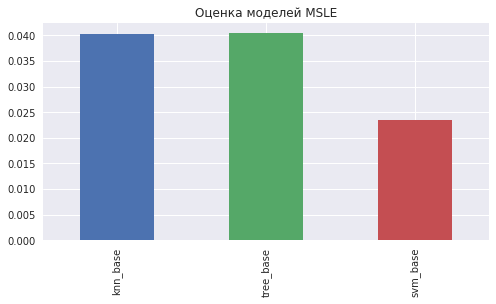

In [50]:
msle_scores.plot(kind='bar', title = 'Оценка моделей MSLE', figsize=(8,4))


Предварительно, лучшей моделью из базовых является SVM.
На этой модели был сделан один из сабмитов на kaggle

### Ансамбли моделей

#### Случайный лес

Проводим поиск по сетке параметров. В конце - лучший средний MSLE на перекрестной проверке, MSLE на тестовом наборе, MSLE на проверочном наборе

In [51]:
rf_pipe = Pipeline([
    ('imputer', Imputer(strategy='mean')),
    ('regressor', RandomForestRegressor(n_estimators=100, bootstrap=True))
])
rf_params = {    
    'regressor__max_features': [0.5, 0.8, 1.0],
    'regressor__max_depth': [10, 15, 20],
    'regressor__min_samples_leaf': [15, 20, 25]
}
rf_grid = GridSearchCV(rf_pipe, param_grid=rf_params, cv=10, n_jobs=-1, scoring='neg_mean_squared_log_error')
rf_grid.fit(X_train, y_train)
print(rf_grid.best_estimator_.named_steps['regressor'])
print('MSLE на cv: {}'.format(-rf_grid.best_score_))
print('MSLE на train: {}'.format(-rf_grid.score(X_train, y_train)))
msle_scores['rand_forest'] = -rf_grid.score(X_test, y_test)
print('MSLE на test: {}'.format(msle_scores['rand_forest']))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=15, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
MSLE на cv: 0.02782804286326481
MSLE на train: 0.020141743370930394
MSLE на test: 0.025080042811638763


#### Особо случайный лес

Проводим поиск по сетке параметров. В конце - лучший средний MSLE на перекрестной проверке, MSLE на тестовом наборе, MSLE на проверочном наборе.

Сетку параметров использовали такую же, как и случайного леса. Особо случайный лес показал точность немного похуже, чем у RandomForestRegressor, но выше скорость работы при подборе параметров.

In [52]:
extree_pipe = Pipeline([
    ('imputer', Imputer(strategy='mean')),
    ('regressor', ExtraTreesRegressor(n_estimators=100, bootstrap=True))
])
extree_params = {    
    'regressor__max_features': [0.5, 0.8, 1.0],
    'regressor__max_depth': [10, 15, 20],
    'regressor__min_samples_leaf': [15, 20, 25]
}
extree_grid = GridSearchCV(extree_pipe, param_grid=extree_params, cv=10, n_jobs=-1, scoring='neg_mean_squared_log_error')
extree_grid.fit(X_train, y_train)
print(extree_grid.best_estimator_.named_steps['regressor'])
print('MSLE на cv: {}'.format(-extree_grid.best_score_))
print('MSLE на train: {}'.format(-extree_grid.score(X_train, y_train)))
msle_scores['ex_trees'] = -extree_grid.score(X_test, y_test)
print('MSLE на test: {}'.format(msle_scores['ex_trees']))

ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=15,
          max_features=1.0, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=15,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
MSLE на cv: 0.0317421799582393
MSLE на train: 0.024730045342563598
MSLE на test: 0.031819523750766354


Сравним результаты лесов с базовыми моделями

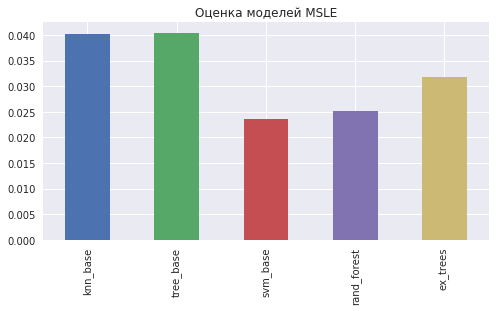

In [53]:
msle_scores.plot(kind='bar', title = 'Оценка моделей MSLE', figsize=(8,4))

Деревянные ансамбли оказались лучше обычного дерева, но лидером все равно остается SVM

#### Оценка важности признаков

Важность признаков можно посмотреть по результату RandomForestRegressor. 

Дополнительно построил важность признаков по Lasso модели (L1-регуляризация), у которой коэффициенты для незначимых признаков будут нулевыми.

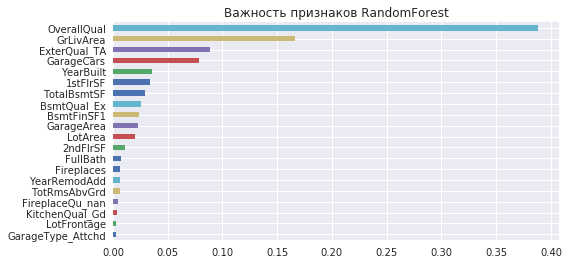

In [54]:
imp = pd.Series(rf_grid.best_estimator_.named_steps['regressor'].feature_importances_, index=X_train.columns)
imp.sort_values(ascending=False).head(20)[::-1].plot(kind='barh', title='Важность признаков RandomForest',  figsize=(8,4))

In [55]:
lasso_pipe = Pipeline([
    ('imputer', Imputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('regressor', Lasso(alpha=50))
])


lasso_pipe.fit(X_train, y_train)
#print(lasso_pipe.score(X_train, y_train))
#print(lasso_pipe.score(X_test, y_test))

Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regressor', Lasso(alpha=50, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])

In [56]:
np.sum(lasso_pipe.named_steps['regressor'].coef_ != 0)

233

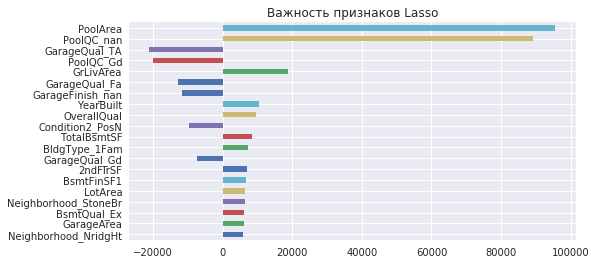

In [57]:
imp_lasso = pd.Series(lasso_pipe.named_steps['regressor'].coef_, index=X_train.columns)
imp_lasso = imp_lasso.reindex(imp_lasso.abs().sort_values(ascending=False).index)
imp_lasso.head(20)[::-1].plot(kind='barh', title='Важность признаков Lasso',  figsize=(8,4))

Дальше можно попробовать базовые модели с автоматическим отбором важных признаков на основе модели случайного леса.

#### Модели с отбором важных признаков

Для всех четырех базовых моделей в конвейер добавляем селектор SelectFromModel с аутоматическим отбором важных признаков случайным лесом. С параметром threshold = 0.01 таких признаков должно быть около 11.
Заново проводим поиск параметров и оценку на проверочном наборе

In [59]:
knn_pipe_selected = Pipeline([
    ('imputer', Imputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('selector', SelectFromModel(RandomForestRegressor(n_estimators=50, random_state=42),threshold = 0.01)),
    ('regressor', KNeighborsRegressor())
])
knn_params = {
        'regressor__n_neighbors': [5, 10, 15, 20] 
}
knn_grid_selected = GridSearchCV(knn_pipe_selected, param_grid=knn_params, cv=10, n_jobs=-1, scoring='neg_mean_squared_log_error')
knn_grid_selected.fit(X_train, y_train)
print(knn_grid_selected.best_estimator_.named_steps['regressor'])
print('MSLE на cv: {}'.format(-knn_grid_selected.best_score_))
print('MSLE на train: {}'.format(-knn_grid_selected.score(X_train, y_train)))
msle_scores['knn_with_selector'] = -knn_grid_selected.score(X_test, y_test)
print('MSLE на test: {}'.format(msle_scores['knn_with_selector']))

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=10, p=2,
          weights='uniform')
MSLE на cv: 0.030709090552992875
MSLE на train: 0.0241059907286073
MSLE на test: 0.027137454982767047


In [60]:
line_pipe_selected = Pipeline([
    ('imputer', Imputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('selector', SelectFromModel(RandomForestRegressor(n_estimators=50, random_state=42),threshold = 0.01)),
    ('regressor', LinearRegression())
])
line_params = [
    {'regressor': [LinearRegression()]},
    {'regressor': [Ridge()], 'regressor__alpha': [0.1, 1, 10]},
    {'regressor': [Lasso()], 'regressor__alpha': [0.1, 1, 10]},
    {'regressor': [ElasticNet()], 'regressor__alpha': [0.01, 0.1, 1],
     'regressor__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]}
]
line_grid_selected = GridSearchCV(line_pipe_selected, param_grid=line_params, cv=10, n_jobs=-1, scoring='r2')
line_grid_selected.fit(X_train, y_train)
print(line_grid_selected.best_estimator_.named_steps['regressor'])
print('R2 на cv: {}'.format(line_grid_selected.best_score_))
print('R2 на train: {}'.format(line_grid_selected.score(X_train, y_train)))
r2_scores['line_with_selector'] = line_grid_selected.score(X_test, y_test)
print('R2 на test: {}'.format(r2_scores['line_with_selector']))

ElasticNet(alpha=1, copy_X=True, fit_intercept=True, l1_ratio=0.9,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
R2 на cv: 0.7570102627755987
R2 на train: 0.7869150472566315
R2 на test: 0.824923281542329


In [61]:
tree_pipe_selected = Pipeline([
    ('imputer', Imputer(strategy='mean')),
    ('selector', SelectFromModel(RandomForestRegressor(n_estimators=50, random_state=42),threshold = 0.01)),
    ('regressor', DecisionTreeRegressor(random_state=42))
])
tree_params = {    
    'regressor__max_depth': [5, 7, 9, 11, 13],
    'regressor__max_features': [0.8, 0.9, 1.0]
}
tree_grid_selected = GridSearchCV(tree_pipe_selected, param_grid=tree_params, cv=10, n_jobs=-1, scoring='neg_mean_squared_log_error')
tree_grid_selected.fit(X_train, y_train)
print(tree_grid_selected.best_estimator_.named_steps['regressor'])
print('MSLE на cv: {}'.format(-tree_grid_selected.best_score_))
print('MSLE на train: {}'.format(-tree_grid_selected.score(X_train, y_train)))
msle_scores['tree_with_selector'] = -tree_grid_selected.score(X_test, y_test)
print('MSLE на test: {}'.format(msle_scores['tree_with_selector']))

DecisionTreeRegressor(criterion='mse', max_depth=7, max_features=1.0,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')
MSLE на cv: 0.040523938278500815
MSLE на train: 0.01666695256990304
MSLE на test: 0.03474558114796175


In [62]:
svm_pipe_selected = Pipeline([
    ('imputer', Imputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('selector', SelectFromModel(RandomForestRegressor(n_estimators=50, random_state=555),threshold = 0.01)),
    ('regressor', SVR())
])
svm_params = {    
    'regressor__C': [100000],
    'regressor__gamma': [ 0.01]
}
svm_grid_selected = GridSearchCV(svm_pipe_selected, param_grid=svm_params, cv=10, n_jobs=-1, scoring='neg_mean_squared_log_error')
svm_grid_selected.fit(X_train, y_train)
print(svm_grid_selected.best_estimator_.named_steps['regressor'])
print('MSLE на cv: {}'.format(-svm_grid_selected.best_score_))
print('MSLE на train: {}'.format(-svm_grid_selected.score(X_train, y_train)))
msle_scores['svm_with_selector'] = -svm_grid_selected.score(X_test, y_test)
print('MSLE на test: {}'.format(msle_scores['svm_with_selector']))

SVR(C=100000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
MSLE на cv: 0.024319410000140537
MSLE на train: 0.02109534562021916
MSLE на test: 0.023618215220263045


Еще раз сравниваем оценки моделей.

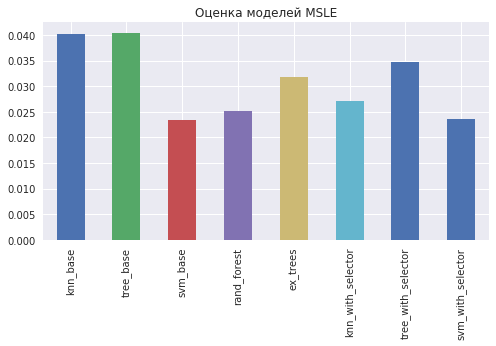

In [63]:
msle_scores.plot(kind='bar', title = 'Оценка моделей MSLE', figsize=(8,4))

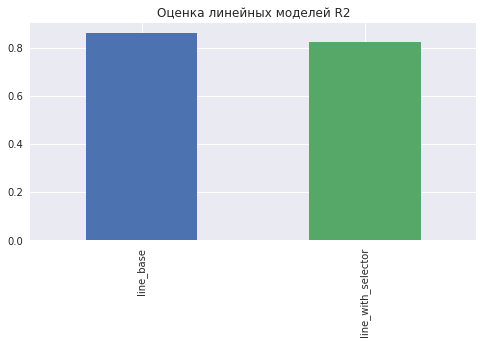

In [64]:

r2_scores.plot(kind='bar', title = 'Оценка линейных моделей R2', figsize=(8,4))

Видно, что отбор важных признаков позволил улучшить все базовые модели, кроме SVM.

#### Бэггинг

На базовых моделях с оптимальными параметрами проводим бэггинг. Результаты сравним на графике в конце.

In [66]:
knn_grid.best_estimator_

Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regressor', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=7, p=2,
          weights='uniform'))])

In [83]:
knn_bag = Pipeline([
    ('imputer', Imputer(strategy='mean')),
    ('scaler', StandardScaler()),
#    ('selector', SelectFromModel(RandomForestRegressor(n_estimators=100, random_state=42),threshold = 0.01)),
    ('regressor', BaggingRegressor(n_estimators=20, 
                                   base_estimator=knn_grid.best_estimator_.named_steps['regressor'], 
                                   random_state=42, 
                                   oob_score=False))
])
knn_bag_params = {    
    'regressor__n_estimators': [20, 30, 40],
}
knn_bag_grid = GridSearchCV(knn_bag, param_grid=knn_bag_params, cv=10, n_jobs=-1, scoring='neg_mean_squared_log_error')
knn_bag_grid.fit(X_train, y_train)
print(knn_bag_grid.best_estimator_.named_steps['regressor'])
print('MSLE на cv: {}'.format(-knn_bag_grid.best_score_))
print('MSLE на train: {}'.format(-knn_bag_grid.score(X_train, y_train)))
msle_scores['knn_bagging'] = -knn_bag_grid.score(X_test, y_test)
print('MSLE на test: {}'.format(msle_scores['knn_bagging']))

BaggingRegressor(base_estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=7, p=2,
          weights='uniform'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=30, n_jobs=1, oob_score=False,
         random_state=42, verbose=0, warm_start=False)
MSLE на cv: 0.04020695532392238
MSLE на train: 0.02918489888944249
MSLE на test: 0.03950263653107912


In [82]:
line_bag = Pipeline([
    ('imputer', Imputer(strategy='mean')),
    ('scaler', StandardScaler()),
#    ('selector', SelectFromModel(RandomForestRegressor(n_estimators=100, random_state=42),threshold = 0.01)),
    ('regressor', BaggingRegressor(n_estimators=20, 
                                   base_estimator=line_grid.best_estimator_.named_steps['regressor'], 
                                   random_state=42, 
                                   oob_score=False))
])
line_bag_params = {    
    'regressor__n_estimators': [20, 30, 40, 50],
}
line_bag_grid = GridSearchCV(line_bag, param_grid=line_bag_params, cv=10, n_jobs=-1, scoring='r2')
line_bag_grid.fit(X_train, y_train)
print(line_bag_grid.best_estimator_.named_steps['regressor'])
print('R2 на cv: {}'.format(line_bag_grid.best_score_))
print('R2 на train: {}'.format(line_bag_grid.score(X_train, y_train)))
r2_scores['line_bagging'] = line_bag_grid.score(X_test, y_test)
print('R2 на test: {}'.format(r2_scores['line_bagging']))

BaggingRegressor(base_estimator=ElasticNet(alpha=10, copy_X=True, fit_intercept=True, l1_ratio=0.9,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=40, n_jobs=1, oob_score=False,
         random_state=42, verbose=0, warm_start=False)
R2 на cv: 0.8077733632761828
R2 на train: 0.8718113926663593
R2 на test: 0.8603440021313571


In [69]:
tree_bag = Pipeline([
    ('imputer', Imputer(strategy='mean')),
#    ('selector', SelectFromModel(RandomForestRegressor(n_estimators=100, random_state=42),threshold = 0.01)),
    ('regressor', BaggingRegressor(n_estimators=20, 
                                   base_estimator=tree_grid.best_estimator_.named_steps['regressor'], 
                                   random_state=42, 
                                   oob_score=False))
])
tree_bag_params = {    
    'regressor__n_estimators': [20, 30, 40, 50, 100],
}
tree_bag_grid = GridSearchCV(tree_bag, param_grid=tree_bag_params, cv=10, n_jobs=-1, scoring='neg_mean_squared_log_error')
tree_bag_grid.fit(X_train, y_train)
print(tree_bag_grid.best_estimator_.named_steps['regressor'])
print('MSLE на cv: {}'.format(-tree_bag_grid.best_score_))
print('MSLE на train: {}'.format(-tree_bag_grid.score(X_train, y_train)))
msle_scores['tree_bagging'] = -tree_bag_grid.score(X_test, y_test)
print('MSLE на test: {}'.format(msle_scores['tree_bagging']))

BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=8, max_features=0.7,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=100, n_jobs=1, oob_score=False,
         random_state=42, verbose=0, warm_start=False)
MSLE на cv: 0.02435569301311809
MSLE на train: 0.006941373619118419
MSLE на test: 0.02134696459083353


In [70]:
svm_bag = Pipeline([
    ('imputer', Imputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('regressor', BaggingRegressor(n_estimators=20, 
                                   base_estimator=svm_grid.best_estimator_.named_steps['regressor'], 
                                   random_state=42, 
                                   oob_score=False))
])
svm_bag_params = {    
    'regressor__n_estimators': [20, 30, 40, 50],
}
svm_bag_grid = GridSearchCV(svm_bag, param_grid=svm_bag_params, cv=10, n_jobs=-1, scoring='neg_mean_squared_log_error')
svm_bag_grid.fit(X_train, y_train)
print(svm_bag_grid.best_estimator_.named_steps['regressor'])
print('MSLE на cv: {}'.format(-svm_bag_grid.best_score_))
print('MSLE на train: {}'.format(-svm_bag_grid.score(X_train, y_train)))
msle_scores['svm_bagging'] = -svm_bag_grid.score(X_test, y_test)
print('MSLE на test: {}'.format(msle_scores['svm_bagging']))

BaggingRegressor(base_estimator=SVR(C=100000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=40, n_jobs=1, oob_score=False,
         random_state=42, verbose=0, warm_start=False)
MSLE на cv: 0.021251131366954515
MSLE на train: 0.008288089128413001
MSLE на test: 0.025244113005607766


Снова взглянем на графики.

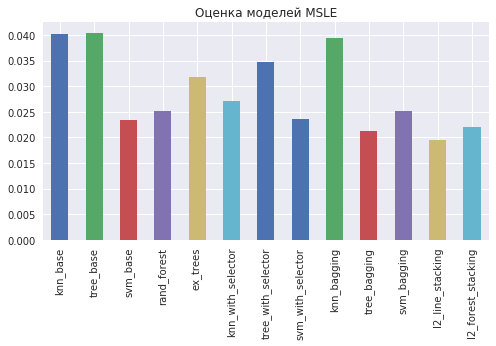

In [85]:
msle_scores.plot(kind='bar', title = 'Оценка моделей MSLE', figsize=(8,4))

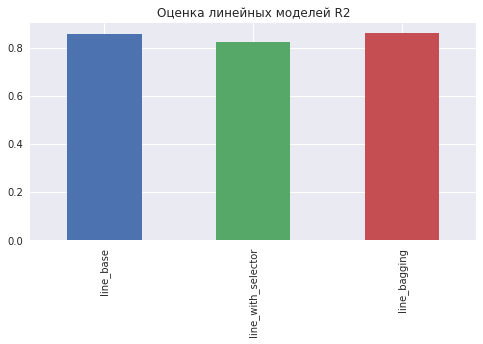

In [86]:
r2_scores.plot(kind='bar', title = 'Оценка линейных моделей R2', figsize=(8,4))

Бэггинг улучшил все базовые модели. Но KNN с отобранный набором признаков улучшить не удалось

#### Стэкинг

Строим два стекинга с разными мета моделями на втором уровне - регуляризованная линейная модель и случайный лес.
В первом уровне используем три из четырех базовых моделей с оптимальными параметрами.

In [73]:
def get_meta_features(clf, X_train, y_train, X_test, stack_cv):
    meta_train = np.zeros_like(X_train.index, dtype=float)
    meta_test = np.zeros_like(X_test.index, dtype=float)
    clf_pipe = Pipeline([
        ('imputer', Imputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('regressor', clf)
    ])
    for train_ind, test_ind in stack_cv.split(X_train, y_train):
        clf_pipe.fit(X_train.iloc[train_ind], y_train.iloc[train_ind])
        meta_train[test_ind] = clf_pipe.predict(X_train.iloc[test_ind])
        meta_test += clf_pipe.predict(X_test)
    return meta_train, meta_test / stack_cv.n_splits


##### Level-1 модели

In [74]:
from sklearn.model_selection import KFold
stack_cv = KFold(n_splits=10, shuffle=True, random_state=555)

#X_meta_train = X_train[num_feat]
#X_meta_test = X_test[num_feat]
X_meta_train = pd.DataFrame(index=X_train.index)
X_meta_test = pd.DataFrame(index=X_test.index)

print('KNN features...')
meta_tr, meta_te = get_meta_features(knn_grid.best_estimator_.named_steps['regressor'], 
                                     X_train, y_train, X_test, stack_cv)
X_meta_train['knn_pred'] = meta_tr
X_meta_test['knn_pred'] = meta_te

print('SVM features...')
meta_tr, meta_te = get_meta_features(svm_grid.best_estimator_.named_steps['regressor'], 
                                     X_train, y_train, X_test, stack_cv)
X_meta_train['svm_pred'] = meta_tr
X_meta_test['svm_pred'] = meta_te

print('LR features...')
meta_tr, meta_te = get_meta_features(line_grid.best_estimator_.named_steps['regressor'], 
                                     X_train, y_train, X_test, stack_cv)
X_meta_train['lr_pred'] = meta_tr
X_meta_test['lr_pred'] = meta_te

print('RF features...')
meta_tr, meta_te = get_meta_features(rf_grid.best_estimator_.named_steps['regressor'], 
                                     X_train, y_train, X_test, stack_cv)
X_meta_train['rf_pred'] = meta_tr
X_meta_test['rf_pred'] = meta_te

KNN features...
SVM features...
LR features...
RF features...


In [75]:
X_meta_train.describe().T

,count,mean,std,min,25%,50%,75%,max
knn_pred,1022.0,174193.133212,57780.143862,81628.571429,132176.785714,160791.785714,202964.285714,450929.000000
svm_pred,1022.0,179111.263341,64582.905496,51974.855475,132112.934579,166809.749395,215679.372763,417447.728929
lr_pred,1022.0,181337.431481,66489.450374,20438.055027,134055.128937,171326.621453,217620.953841,659745.598517
rf_pred,1022.0,181460.582801,62452.293494,85465.110350,134790.623532,167395.943488,211952.229936,392792.502718


In [76]:
X_meta_train.shape, X_meta_test.shape

((1022, 4), (438, 4))

##### Level-2 модели

In [ ]:
#meta_feat_lr = ['knn_pred', 'svm_pred', 'rf_pred', 'lr_pred']
level2_lr = Pipeline([
    ('imputer', Imputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('regressor', Ridge())
])
level2_lr_params = [
    {'regressor': [Ridge()], 'regressor__alpha': [0.01, 0.1, 1, 10, 100]},
    {'regressor': [Lasso()], 'regressor__alpha': [0.01, 0.1, 1, 10, 100]},
    {'regressor': [ElasticNet()], 'regressor__alpha': [0.01, 0.1, 1, 10, 100],
     'regressor__l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}
]
level2_lr_grid = GridSearchCV(level2_lr, param_grid=level2_lr_params, cv=10, n_jobs=-1, scoring='neg_mean_squared_log_error')
level2_lr_grid.fit(X_meta_train, y_train)
print(level2_lr_grid.best_estimator_.named_steps['regressor'])
print('MSLE на cv: {}'.format(-level2_lr_grid.best_score_))
print('MSLE на train: {}'.format(-level2_lr_grid.score(X_meta_train[meta_feat_lr], y_train)))
msle_scores['l2_line_stacking'] = -level2_lr_grid.score(X_meta_test[meta_feat_lr], y_test)
print('MSLE на test: {}'.format(msle_scores['l2_line_stacking']))

In [ ]:
#meta_feat_lr = ['knn_pred', 'svm_pred', 'rf_pred', 'lr_pred']
level2_rf = Pipeline([
    ('imputer', Imputer(strategy='mean')),
#    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor())
])
level2_rf_params = [
    {'regressor': [RandomForestRegressor()], 
     'regressor__n_estimators': [50, 100, 150, 200],
     'regressor__max_features': [0.5, 0.8, 1.0],
     'regressor__max_depth': [10, 15, 20],
     'regressor__min_samples_leaf': [15, 20, 25]}
]
level2_rf_grid = GridSearchCV(level2_rf, param_grid=level2_rf_params, cv=10, n_jobs=-1, scoring='neg_mean_squared_log_error')
level2_rf_grid.fit(X_meta_train, y_train)
print(level2_rf_grid.best_estimator_.named_steps['regressor'])
print('MSLE на cv: {}'.format(-level2_rf_grid.best_score_))
print('MSLE на train: {}'.format(-level2_rf_grid.score(X_meta_train[meta_feat_rf], y_train)))
msle_scores['l2_forest_stacking'] = -level2_rf_grid.score(X_meta_test[meta_feat_rf], y_test)
print('MSLE на test: {}'.format(msle_scores['l2_forest_stacking']))

#### Итог. Лучшая модель

На локальной валидации лучший результат показал стекинг с линейной мета моделью.
На втором и третьем месте бэггинг SVM и базовый SVM.
Сделал три сабмита на kaggle предсказаний на основе этих трех моделей.
Неожиданно, но на kaggle learedboard наилучший результат оказался у бэггинга SVM (1334 место в общем зачете), даже выше стекинга.

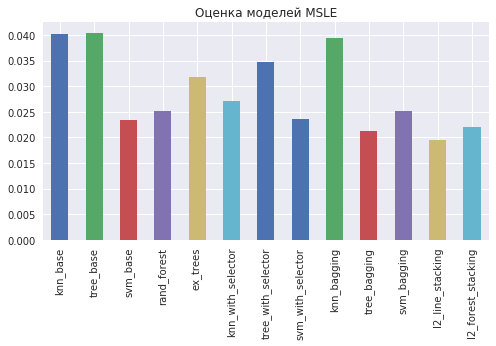

In [79]:
msle_scores.plot(kind='bar', title = 'Оценка моделей MSLE', figsize=(8,4))

### Сабмит на Kaggle

Проводим обучение лучшей стекинг модели на всем тренировочном наборе с kaggle и делаем предсказания на проверочно X_val

In [89]:
stack_cv = KFold(n_splits=10, shuffle=True, random_state=555)

#X_meta_train = X_full[num_feat]
#X_meta_test = X_val[num_feat]
X_meta_train = pd.DataFrame(index=X_full.index)
X_meta_test = pd.DataFrame(index=X_val.index)

print('KNN features...')
meta_tr, meta_te = get_meta_features(knn_grid.best_estimator_.named_steps['regressor'],
                                     X_full, y_full, X_val, stack_cv)
X_meta_train['knn_pred'] = meta_tr
X_meta_test['knn_pred'] = meta_te

print('SVM features...')
meta_tr, meta_te = get_meta_features(svm_grid.best_estimator_.named_steps['regressor'],
                                     X_full, y_full, X_val, stack_cv)
X_meta_train['svm_pred'] = meta_tr
X_meta_test['svm_pred'] = meta_te

print('LR features...')
meta_tr, meta_te = get_meta_features(line_grid.best_estimator_.named_steps['regressor'],
                                     X_full, y_full, X_val, stack_cv)
X_meta_train['lr_pred'] = meta_tr
X_meta_test['lr_pred'] = meta_te

print('RF features...')
meta_tr, meta_te = get_meta_features(rf_grid.best_estimator_.named_steps['regressor'],
                                     X_full, y_full, X_val, stack_cv)
X_meta_train['rf_pred'] = meta_tr
X_meta_test['rf_pred'] = meta_te

level2_lr_grid.fit(X_meta_train, y_full)
print(level2_lr_grid.best_estimator_.named_steps['regressor'])
print('MSLE на cv: {}'.format(-level2_lr_grid.best_score_))
print('MSLE на val: {}'.format(-level2_lr_grid.score(X_meta_train, y_full)))
predictions = level2_lr_grid.predict(X_meta_test)


KNN features...
SVM features...
LR features...
RF features...
ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.3,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
MSLE на cv: 0.016825509785955563
MSLE на val: 0.016560031149652227


In [90]:
#predictions = svm_bag_grid.fit(X_full,y_full).predict(X_val)
submussion = 'Id,SalePrice\n'
submussion += "\n".join(["{},{}".format(pid, prediction) for pid, prediction in zip(X_val.index, predictions)])
with open('submission.txt', 'w') as file:
    file.write(submussion)
